In [ ]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

In [ ]:
from binsense.config import DATA_DIR
print(DATA_DIR)

import binsense.dataprep.downloader as d
d.download()

import binsense.dataprep.metadata as m
bin_df, item_df = m.load()
print(bin_df.shape, item_df.shape)


In [ ]:
from binsense.owlv2 import hugg_loader as l
from binsense.owlv2 import Owlv2Config
from binsense.owlv2 import Owlv2ForObjectDetection, Owlv2ImageProcessor
import numpy as np

processor = Owlv2ImageProcessor(**l.load_owlv2processor_config())
model = Owlv2ForObjectDetection(Owlv2Config(**l.load_owlv2model_config()))
model.load_state_dict(l.load_owlv2model_statedict())
model.eval()
print()

In [ ]:
import torch
import PIL

from binsense.config import BIN_S3_DOWNLOAD_IMAGES_DIR as imgdir
from scipy.special import expit as sigmoid

def get_topk_bboxes(image_path, topk):
    sample_image = PIL.Image.open(image_path)
    image_pixels = processor.preprocess(sample_image)['pixel_values']

    with torch.no_grad():
        image_embeds, _ = model.image_embedder(image_pixels)
        bbox_logits  = model.objectness_predictor(image_embeds)
        bboxes = model.box_predictor(image_embeds)
        # print('embeds=', image_embeds.shape, ', bbox_logits=', bbox_logits.shape, ', bboxes=',  bboxes.shape)
        
    padded_item_image = PIL.Image.fromarray(processor.unnormalize_pixels(image_pixels)[0])
    target_sizes = torch.Tensor([padded_item_image.size[::-1]])
    boxes = processor.post_process_bounding_boxes(boxes=bboxes, target_sizes=target_sizes)
    boxes = np.array(boxes[0].detach())
    objectnesses = np.array(bbox_logits[0].detach())

    # Plot top k objects on Query Item Image
    topk_boxscores = []
    
    objectnesses = sigmoid(objectnesses)
    topk_objectness = sorted([(i, score) for i, score in enumerate(objectnesses)], key=lambda x: x[1], reverse=True)[:topk]
    # objectness_threshold = np.partition(objectnesses, -topk)[-topk]

    for i, score in topk_objectness:
        # if objectness < objectness_threshold:
        #     continue
        topk_boxscores.append((boxes[i], score))
        
    return padded_item_image, topk_boxscores

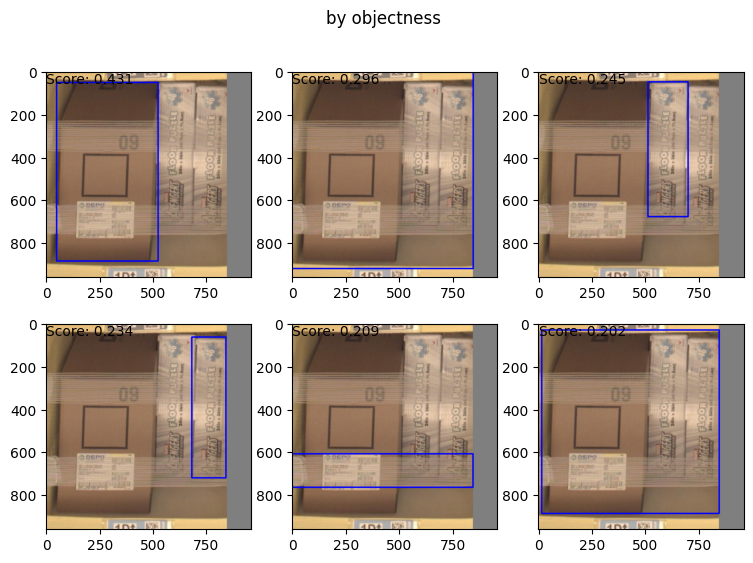

In [ ]:
from binsense.plot_utils import show_bbox_ingrid

img, box_scores = get_topk_bboxes('../docs/sample_bin.jpg', 6)
show_bbox_ingrid(np.array(img), box_scores, grid=(2, 3), title="by objectness")

0.5714285969734192 0.5714285714285714
0.4000000059604645 0.4
0.5 0.5


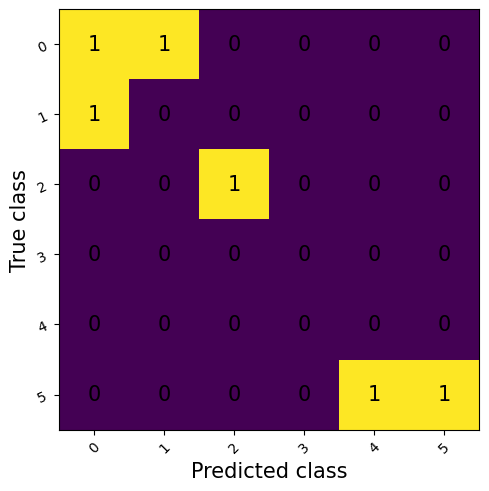

In [12]:
from binsense.lightning.metrics import QueryAccuracy
from binsense import torch_utils as tutls
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt

exists_acc = QueryAccuracy(criteria="exists")
exists_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
exists_acc(
    preds=tutls.to_int_tensor([1, 2]), 
    targets=tutls.to_int_tensor([0, 2]))
val = exists_acc.compute().item()
print(val, 4/7)
assert round(4/7, 1) == round(val, 1)

matches_acc = QueryAccuracy(criteria="matches")
matches_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
val = matches_acc.compute().item()
print(val, 2/5)
assert round(2/5, 1) == round(val, 1)

meets_acc = QueryAccuracy(criteria="meets")
meets_acc(
    preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10]), 
    targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5]))
val = meets_acc.compute().item()
print(val, 3/6)
assert round(3/6, 1) == round(val, 1)

conf_matrix = MulticlassConfusionMatrix(num_classes=6)
preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10])
targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5])
pred_classes = preds.clone()
pred_classes[pred_classes > 4] = 5
tgt_classes = targets.clone()
tgt_classes[tgt_classes > 4] = 5
conf_matrix(pred_classes, tgt_classes)
conf_matrix.plot()
plt.show()


In [1]:

from binsense.lightning.config import Config as TrainConfig
from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.dataset import LitInImageQuerierDM
from binsense.lightning.model import LitInImageQuerier
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.cli.owlv2.train import train, _get_baseline_model
from binsense import torch_utils as tutls
import logging, PIL, torch
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

def _get_transform_fn(embed_ds):
    processor = Owlv2ImageProcessor()
    def transform(inputs):
        inputs['image'] = processor.preprocess(inputs['image'])['pixel_values'][0]
        inputs['query'] = embed_ds.get(inputs['query']).reshape((1, -1))
        return inputs
    return transform

cfg = TrainConfig()
embed_ds = SafeTensorEmbeddingDatastore(cfg.embed_store_dirpath, read_only=True)
data_module = LitInImageQuerierDM(
    data_dir=cfg.data_dirpath,
    csv_filepath=cfg.data_csv_filepath, 
    batch_size=2, 
    num_workers=0, transform=_get_transform_fn(embed_ds))
data_module.setup(stage=None)
lmodel = LitInImageQuerier(_get_baseline_model())

def check_for_empty(dl, desc):
    for batch in tqdm(dl, desc=desc):
        if len(batch[0]) == 0 or len(batch[1]) == 0:
            print("empty batch")

train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()

image_path = '/Users/n0c09jf/code/github/binsense/_data/bin/filtered_dataset/train/images/02278.jpg'
inputs_0 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00K5NELR0"})
inputs_1 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00PLRGOKC"})
inputs = { 
        "image": torch.stack([inputs_0["image"],  inputs_1["image"]]), 
        "query": torch.stack([inputs_0["query"], inputs_1["query"]]),
        "idx": torch.stack([tutls.to_int_tensor(198), tutls.to_int_tensor(199)])
}

gt_labels = [tutls.empty_int_tensor(), tutls.to_int_tensor([0, 0])]
gt_counts = [tutls.to_int_tensor(0), tutls.to_int_tensor(2)]
gt_boxes = [
    tutls.empty_float_tensor(), 
    tutls.to_float_tensor([[0.4919262230396271, 0.5147766323024056, 0.32922131147540984,0.8304810996563573], 
                           [0.7953483462333679, 0.5082130584192439, 0.3489344262295082, 0.7902061855670103]])
]
targets = {
    "count": gt_counts,
    "labels": gt_labels,
    "boxes": gt_boxes
}
print(lmodel.training_step((inputs, targets), 0))
# outputs = lmodel.model(inputs)
# lmodel.loss(outputs, targets)
# print(outputs["pred_boxes"].shape, outputs["pred_logits"].shape, targets)
# preds = lmodel.select_preds(outputs)
# print(lmodel._compute_metrics(preds, targets, 'train', inputs["idx"]))
# [p.shape for p in preds["pred_boxes"]]

# check_for_empty(train_dl, "train_dl")
# check_for_empty(val_dl, "val_dl")

# for i, batch in tqdm(enumerate(train_dl), desc="train_dl"):
#     if len(batch[1]["boxes"]) != 2:
#         print(batch[0]["idx"])
        
#     if batch[1]["boxes"][1].shape[0] == 2 \
#         and batch[1]["boxes"][1][0].shape[0] > 1 \
#         and batch[1]["boxes"][1][0][0].item() == 0.4919262230396271:
#         print(batch[1])
#         outputs = lmodel.model(batch[0])
#         if len(outputs["pred_boxes"]) == 0:
#             print(batch[0]["idx"])
#         else:
#             preds = lmodel.select_preds(outputs)
#             if len(preds["pred_boxes"]) == 0:
#                 print(batch[0]["idx"])


2024-04-12 06:46:17,123 INFO : 
                train/val/test split, 
                len=1007/95/140, 
                ratio=0.8/0.1/0.1
            
2024-04-12 06:46:18,475 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.


tensor(12.9016, grad_fn=<AddBackward0>)


/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [1]:
from binsense.cli.owlv2.train import train
from binsense.lightning.config import Config as TrainConfig
from lightning.pytorch.loggers import TensorBoardLogger
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')
cfg = TrainConfig()
tlogger = TensorBoardLogger(cfg.tb_logs_dir, version='test')
train(
    baseline_model=True, 
    epochs=1, 
    batch_size=2, 
    fast_dev_run=2,
    logger=tlogger,
    profiler='simple'
)

Config(data_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin', data_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/inimage_queries.csv', embed_store_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/embed_store', chkpt_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/chkpts', results_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/test_results.csv', learning_rate=1e-07, epochs=1, min_epochs=10, max_epochs=500, batch_size=2, num_workers=0, reg_loss_coef=0.5, giou_loss_coef=1.0, label_loss_coef=1.5, eos_coef=1.0, use_focal_loss=False, focal_loss_alpha=0.25, focal_loss_gamma=2.0)


2024-04-17 06:28:16,657 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 2 batch(es). Logging and checkpointing is suppressed.
2024-04-17 06:28:20,858 INFO : 
                train/val/test split, 
                len=1015/101/126, 
                ratio=0.8/0.1/0.1
            

   | Name              | Type                | Params
-----------------------------------------------------------
0  | model             | OwlV2InImageQuerier | 91.2 M
1  | loss              | DETRMultiBoxLoss    | 0     
2  | train_exists_acc  | QueryAccuracy       | 0     
3  | val_exists_acc    | QueryAccuracy       | 0     
4  | test_exists_acc   | QueryAccuracy       | 0     
5  | train_matches_acc | QueryAccuracy       | 0     
6  | val_matches_acc   | QueryA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                    

In [2]:
from binsense.lightning.config import Config as TrainConfig
from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.dataset import LitInImageQuerierDM
from binsense.lightning.model import LitInImageQuerier
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.cli.owlv2.train import train, _get_baseline_model
from binsense import torch_utils as tutls
import lightning as L
import logging, PIL, torch
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

def _get_transform_fn(embed_ds):
    processor = Owlv2ImageProcessor()
    def transform(inputs):
        inputs['image'] = processor.preprocess(inputs['image'])['pixel_values'][0]
        inputs['query'] = embed_ds.get(inputs['query']).reshape((1, -1))
        return inputs
    return transform

cfg = TrainConfig()
embed_ds = SafeTensorEmbeddingDatastore(cfg.embed_store_dirpath, read_only=True)
data_module = LitInImageQuerierDM(
    data_dir=cfg.data_dirpath,
    csv_filepath=cfg.data_csv_filepath, 
    batch_size=2, 
    num_workers=0, transform=_get_transform_fn(embed_ds))
data_module.setup(stage=None)
lmodel = LitInImageQuerier(_get_baseline_model())
trainer = L.Trainer(fast_dev_run=2)
trainer.test(model=lmodel, datamodule=data_module)

2024-04-17 06:24:09,175 INFO : 
                train/val/test split, 
                len=1015/101/126, 
                ratio=0.8/0.1/0.1
            


2024-04-17 06:24:13,462 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 2 batch(es). Logging and checkpointing is suppressed.
2024-04-17 06:24:17,726 INFO : 
                train/val/test split, 
                len=1015/101/126, 
                ratio=0.8/0.1/0.1
            
/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

2024-04-17 06:24:17,815 INFO : backing up /Users/n0c09jf/code/github/binsense/_data/bin/test_results.csv to /Users/n0c09jf/code/github/binsense/_data/bin/test_results.csv.1.bkp
/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
